# Brain Tumor Classification

## Initialization

### Imports

In [18]:
import os 
import numpy as np
import torch
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import cv2

### Seeds and Init

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
    print("Using GPU")
else:
    print("Using CPU")

torch.backends.cudnn.benchmark = True
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

Using CPU


## Data Exploration

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

Task 1: We need to explore the dataset. Start off by printing the number of images in each class. We need to know how many images there are in each class for both the training and testing sets. Next, we need to create a function that allows us to visualize the images in the dataset randomly (using the os library). For this visualization, we need to use matplotlib to visualize and the title of the image should be the class of the image. 

## Data Preprocessing

Task 2: We need to work on preprocessing the dataset. The best way to do this would be to first load the dataset by making it into a dataset object and then applying transformations using PyTorch.

In [13]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [14]:
def data_count(main_path = './Dataset/Training/'):
    counts = {}
    for root, dirs, files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in classes:
            counts[str(root.split('/')[-1])] = len(files)
    return counts

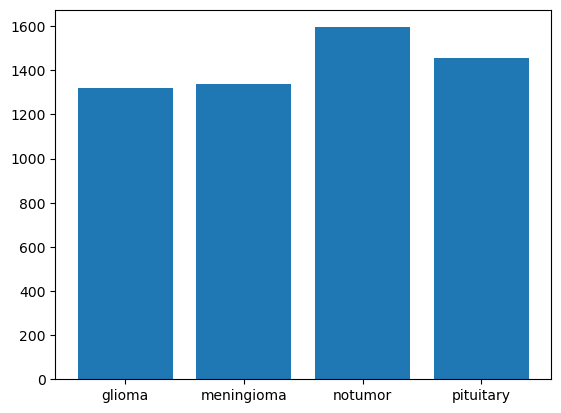

In [15]:
counts = data_count()
plt.bar(list(counts.keys()), list(counts.values()))
plt.show()

In [16]:
def data_split(main_path = './Dataset/Training/', split_percentage=0.3):
    train_dict = {}
    valid_dict = {}
    counts = data_count(main_path)
    for root, dirs, files in os.walk(main_path):
        if files != [] and str(root.split('/')[-1]) in ['glioma', 'meningioma', 'notumor', 'pituitary']:
            file_paths = [os.path.join(root, files[i]) for i in range(len(files))]

            valid_idxs = np.random.randint(low=0, high=len(files), size=int(len(files) * split_percentage))
            train_idxs = list(set(range(0, len(files))) - set(valid_idxs))

            train_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in train_idxs]
            valid_dict[str(root.split('/')[-1])] = [file_paths[idx] for idx in valid_idxs]
    
    return train_dict, valid_dict

In [17]:
train_dict, valid_dict = data_split()

In [19]:
def visualize(data_dict):
    idx = np.random.randint(0,min(list([len(l) for l in data_dict.values()])))

    plt.figure(figsize=(20,6))
    plt.subplot(161)
    plt.imshow(cv2.imread(train_dict['glioma'][idx]).astype(int))
    plt.title('Glioma')
    plt.subplot(162)
    plt.imshow(cv2.imread(train_dict['meningioma'][idx]).astype(int))
    plt.title('Meningioma')
    plt.subplot(163)
    plt.imshow(cv2.imread(train_dict['notumor'][idx]).astype(int))
    plt.title('No Tumor')
    plt.subplot(164)
    plt.imshow(cv2.imread(train_dict['pituitary'][idx]).astype(int))
    plt.title('Pituitary')
    plt.show()

In [20]:
train_dict.keys()

dict_keys(['glioma', 'meningioma', 'notumor', 'pituitary'])

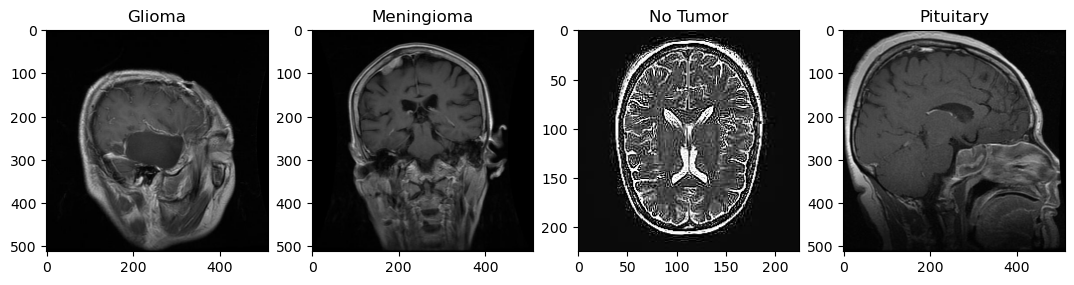

In [21]:
visualize(train_dict)

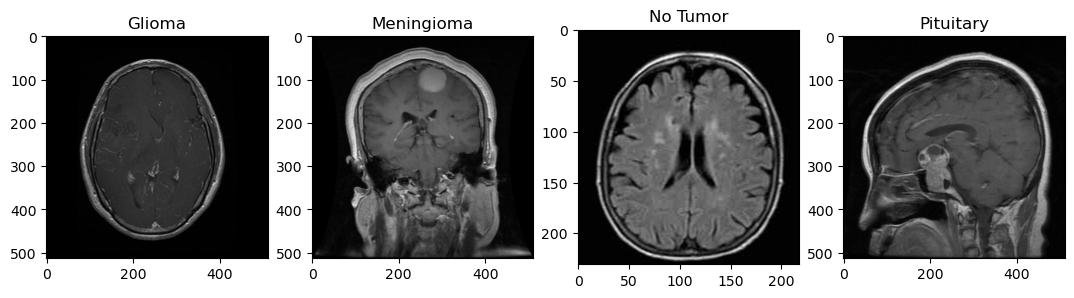

In [22]:
visualize(valid_dict)

In [23]:
print('training data sizes : ', [len(l) for l in train_dict.values()])
print('validation data sizes : ', [len(l) for l in valid_dict.values()])

training data sizes :  [994, 994, 1178, 1080]
validation data sizes :  [396, 401, 478, 437]


In [24]:
class MRIDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        """
        data_dict: dictionary with class as key and corresponding paths to data of that class
        """
        self.data_dict = data_dict
        self.transform = transform
    
    def __len__(self):
        return sum([len(l) for l in self.data_dict.values()])
    
    def __getitem__(self, idx):
        counts = [len(l) for l in self.data_dict.values()]
        sum_counts = list(np.cumsum(counts))
        sum_counts = [0] + sum_counts + [np.inf]

        for c,v in enumerate(sum_counts):
            if idx < v:
                i = (idx - sum_counts[c-1]) - 1
                break
        
        label = list(self.data_dict.keys())[c-1]
        img = Image.open(self.data_dict[str(label)][i]).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, classes.index(str(label))

In [27]:
data_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomVerticalFlip(),
     transforms.RandomHorizontalFlip(),
     transforms.Resize((224, 224)),
     transforms.Normalize((0.5), (0.5))]
)

data_train = MRIDataset(train_dict, transform=data_transform)
data_valid = MRIDataset(valid_dict, transform=data_transform)

c:\Users\sadie\Anaconda3\envs\test_torch_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total number of training images:  4246
Total number of validation images:  1712


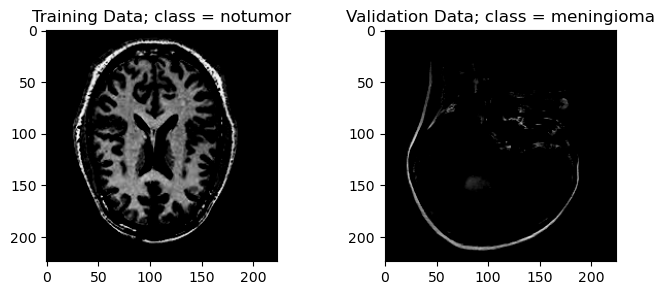

In [28]:
t_idx = np.random.randint(0, len(data_train))
v_idx = np.random.randint(0, len(data_valid))

print("Total number of training images: ", len(data_train))
print("Total number of validation images: ", len(data_valid))

t_img, t_label = data_train[t_idx]
v_img, v_label = data_valid[v_idx]

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(t_img.numpy().transpose(1,2,0))
plt.title(f'Training Data; class = {classes[t_label]}')
plt.subplot(122)
plt.imshow(v_img.numpy().transpose(1,2,0))
plt.title(f'Validation Data; class = {classes[v_label]}')
plt.show()

In [29]:
train_loader = DataLoader(data_train, batch_size=50, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=50, shuffle=True)

In [30]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(), sample_batched[1])
    print(type(sample_batched[0]))
    break

c:\Users\sadie\Anaconda3\envs\test_torch_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0 torch.Size([50, 3, 224, 224]) tensor([3, 3, 1, 2, 0, 3, 3, 3, 1, 1, 3, 1, 1, 2, 3, 3, 2, 1, 2, 1, 3, 0, 1, 1,
        1, 1, 3, 3, 3, 2, 3, 1, 1, 0, 2, 3, 1, 0, 1, 1, 1, 0, 2, 0, 0, 2, 3, 0,
        3, 0])
<class 'torch.Tensor'>
